In [22]:
#imports
import random
import pandas as pd
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
random.seed(22)

In [24]:
#data source: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE38875
# Schraiber JG, Mostovoy Y, Hsu TY, Brem RB. Inferring evolutionary histories of pathway regulation 
# from transcriptional profiling data. PLoS Comput Biol 2013;9(10):e1003255. PMID: 24130471


parents = pd.read_csv('/Users/clairedubin/spur/publishable_data/external_datasets/schraiber_homozygote_exp.csv', header=0).transpose()
parents.columns = parents.iloc[0]
parents = parents.iloc[1:]
parents = parents.apply(pd.to_numeric, errors='coerce')


hybrid = pd.read_csv('/Users/clairedubin/spur/publishable_data/external_datasets/schraiber_hybrid_exp.csv').transpose()
hybrid.columns = hybrid.iloc[0]
hybrid = hybrid.iloc[1:]
hybrid = hybrid.apply(pd.to_numeric, errors='coerce')

In [25]:
#merge parents and hybrid


merged = parents.merge(hybrid,left_index=True, right_index=True,  suffixes=['_parent', '_hybrid'])
merged.head()

Unnamed: 0,S_cerevisiae_parent,S_paradoxus_parent,S_mikatae_parent,S_bayanus_parent,S_cerevisiae_hybrid,S_paradoxus_hybrid,S_mikatae_hybrid,S_bayanus_hybrid
YAL001C,0.0,-2.583948,-1.722466,-0.565701,0.0,0.466195,-0.739996,-0.739367
YAL002W,0.0,0.483679,0.825502,-0.690316,0.0,-1.447409,0.480763,-1.449859
YAL003W,0.0,2.149200,-1.147957,-0.734184,0.0,0.709377,-0.613797,0.177305
YAL007C,0.0,0.657554,0.175662,-3.324163,0.0,1.054652,0.639785,-2.621548
YAL008W,0.0,-1.801968,1.683672,-0.317679,0.0,-1.257800,0.643062,-3.194473


In [26]:
#remove any genes not tested in dxy
dxy = pd.read_csv('/Users/clairedubin/spur/publishable_data/raw_data/dxy_SpA_vineyard_011420.csv')['Unnamed: 0'].tolist()
dxy_genes = [s.split('_')[2] for s in dxy]
parents = parents[parents.index.isin(dxy_genes)]
hybrid = hybrid[hybrid.index.isin(dxy_genes)]
merged = merged[merged.index.isin(dxy_genes)]

In [27]:
#load go term data as go_terms, remove 3 broad go terms
#source: http://geneontology.org/docs/download-go-annotations/

go_terms = pd.read_csv('/Users/clairedubin/spur/publishable_data/external_datasets/go_terms.csv', header=None)
go_terms = go_terms.drop(columns=[0, 1,3,5,6,7,8,11,12,13,14,15])
go_terms = go_terms.rename(columns={2: 'sgd_name', 4:'go_term', 9:'gene_desc', 10:'gene'})
go_terms['gene'] = [i[0] for i in go_terms['gene'].str.split('|')]
go_terms = go_terms.drop_duplicates()
go_terms = go_terms[~go_terms['go_term'].isin(['GO:0005575', 'GO:0008150', 'GO:0003674'])]
go_terms = go_terms.set_index('gene')
go_terms.head()

,sgd_name,go_term,gene_desc
gene,,,
YDL159W,STE7,GO:0000187,Signal transducing MAP kinase kinase
YJL128C,PBS2,GO:0000187,MAP kinase kinase of the HOG signaling pathway
YOL144W,NOP8,GO:0003723,Nucleolar protein required for 60S ribosomal s...
YIL095W,PRK1,GO:0120133,Ser/Thr protein kinase
YER038W-A,FMP49,GO:0005739,Mitochondrial protein of unknown function


In [28]:
#load list of essential genes as essential_genes
#source: http://www-sequence.stanford.edu/group/yeast_deletion_project/Essential_ORFs.txt

essential = pd.read_csv('/Users/clairedubin/spur/publishable_data/external_datasets/essential.csv', header=None)
essential[1] = essential[1].str.strip('\t')
essential_genes = essential[1].str.strip(' ').tolist()

In [29]:
#split expression data into essential and non essential genes

essential_parents = parents[parents.index.isin(essential_genes)]
non_essential_parents = parents[~parents.index.isin(essential_genes)]

essential_hybrid = hybrid[hybrid.index.isin(essential_genes)]
non_essential_hybrid = hybrid[~hybrid.index.isin(essential_genes)]

essential_merged = merged[merged.index.isin(essential_genes)]
non_essential_merged = merged[~merged.index.isin(essential_genes)]

In [30]:
#merge GO term and expression data

merged_parents = go_terms.merge(parents, left_index=True, right_index=True)
merged_hybrid = go_terms.merge(hybrid, left_index=True, right_index=True)
merged = go_terms.merge(merged, left_index=True, right_index=True)

In [31]:
#group by GO term
go_term_groups_merged = merged.groupby('go_term').count()

medians_merged = merged.groupby('go_term').median().add_suffix('_median')
medians_merged_abs = merged.set_index('go_term').drop(columns=['sgd_name', 'gene_desc']).groupby('go_term').median().abs().add_suffix('_abs_median')
medians_merged_abs_mean = merged.set_index('go_term').drop(columns=['sgd_name', 'gene_desc']).groupby('go_term').mean().abs().add_suffix('_abs_mean')


medians_merged = medians_merged.merge(medians_merged_abs, right_index=True, left_index=True
                                    )

medians_merged = medians_merged.merge(medians_merged_abs_mean, right_index=True, left_index=True
                                    )

medians_merged.head()

,S_cerevisiae_parent_median,S_paradoxus_parent_median,S_mikatae_parent_median,S_bayanus_parent_median,S_cerevisiae_hybrid_median,S_paradoxus_hybrid_median,S_mikatae_hybrid_median,S_bayanus_hybrid_median,S_cerevisiae_parent_abs_median,S_paradoxus_parent_abs_median,...,S_mikatae_hybrid_abs_median,S_bayanus_hybrid_abs_median,S_cerevisiae_parent_abs_mean,S_paradoxus_parent_abs_mean,S_mikatae_parent_abs_mean,S_bayanus_parent_abs_mean,S_cerevisiae_hybrid_abs_mean,S_paradoxus_hybrid_abs_mean,S_mikatae_hybrid_abs_mean,S_bayanus_hybrid_abs_mean
go_term,,,,,,,,,,,,,,,,,,,,,
GO:0000001,0.0,-0.720716,-1.036188,0.325654,0.0,-0.354269,-0.057990,-0.156160,0.0,0.720716,...,0.057990,0.156160,0.0,0.380921,0.846618,0.170537,0.0,0.449251,0.226274,0.451517
GO:0000002,0.0,-0.463690,-0.301350,-0.216262,0.0,0.364962,0.037637,-0.110633,0.0,0.463690,...,0.037637,0.110633,0.0,0.203454,0.315556,0.192688,0.0,0.337827,0.009248,0.023020
GO:0000006,0.0,2.656452,-0.086885,-1.379462,0.0,-0.485809,-1.099629,-5.898581,0.0,2.656452,...,1.099629,5.898581,0.0,2.656452,0.086885,1.379462,0.0,0.485809,1.099629,5.898581
GO:0000007,0.0,0.185762,-0.126757,1.884007,0.0,-0.496289,-1.265057,-0.026094,0.0,0.185762,...,1.265057,0.026094,0.0,0.185762,0.126757,1.884007,0.0,0.496289,1.265057,0.026094
GO:0000009,0.0,0.679665,0.511308,0.671403,0.0,0.694457,0.762434,0.722962,0.0,0.679665,...,0.762434,0.722962,0.0,0.491043,0.562277,0.479486,0.0,0.545207,0.813736,0.786091


In [32]:
#eliminate GO terms with less than 80% of genes used in MK test or less than 10 genes tested
go_term_other = pd.read_csv('/Users/clairedubin/spur/publishable_data/raw_data/population_test_data_by_go_term_50percentcutoff_081419.csv')
go_terms_to_use = go_term_other[(go_term_other['tested_gene_counts']/go_term_other['total_gene_counts'] > .75) & (go_term_other['total_gene_counts'] > 10) ]['go_term'].tolist()


go_term_groups_75_merged = medians_merged[medians_merged.index.isin(go_terms_to_use)]
go_term_groups_75_merged = go_term_other.merge(go_term_groups_75_merged, right_index=True, left_on='go_term').set_index('go_term')

In [33]:
go_term_groups_75_merged.shape

(167, 38)

In [34]:
#resample function

def resample_old(go_term):
    
    loc = go_term_groups_75_merged.loc[go_term]

    gene_list = ast.literal_eval(loc['tested_gene_list'])
    essential_count = loc['tested_essential_count']
    non_essential_count = len(gene_list) - essential_count
    
    parent_spar_median, parent_smik_median, parent_sbay_median = loc['S_paradoxus_parent_median'], loc['S_mikatae_parent_median'], loc['S_bayanus_parent_median']
    hybrid_spar_median, hybrid_smik_median, hybrid_sbay_median = loc['S_paradoxus_hybrid_median'], loc['S_mikatae_hybrid_median'], loc['S_bayanus_hybrid_median']

    print(parent_spar_median, hybrid_spar_median)
    
    parent_spar_count, parent_smik_count, parent_sbay_count = 0,0,0
    hybrid_spar_count, hybrid_smik_count, hybrid_sbay_count = 0,0,0
    
    for i in range(10000):

        sample = essential_merged.sample(n=essential_count,replace=True)
        sample = sample.append(non_essential_merged.sample(n=non_essential_count,replace=True))

        sample_parent_spar_median, sample_parent_smik_median, sample_parent_sbay_median = sample['S_paradoxus_parent'].median(), sample['S_mikatae_parent'].median(), sample['S_bayanus_parent'].median()
        sample_hybrid_spar_median, sample_hybrid_smik_median, sample_hybrid_sbay_median = sample['S_paradoxus_hybrid'].median(), sample['S_mikatae_hybrid'].median(), sample['S_bayanus_hybrid'].median()

        if sample_parent_spar_median > parent_spar_median:
            parent_spar_count += 1
            
        if sample_parent_smik_median > parent_smik_median:
            parent_smik_count += 1
        
        if sample_parent_sbay_median > parent_sbay_median:
            parent_sbay_count += 1            
        
        if sample_hybrid_spar_median > hybrid_spar_median:
            hybrid_spar_count += 1
            
        if sample_hybrid_smik_median > hybrid_smik_median:
            hybrid_smik_count += 1
        
        if sample_hybrid_sbay_median > hybrid_sbay_median:
            hybrid_sbay_count += 1              


    print(go_term, parent_spar_count/10000, parent_smik_count/10000, parent_sbay_count/10000,
         hybrid_spar_count/10000, hybrid_smik_count/10000, hybrid_sbay_count/10000,)
    return [parent_spar_count/10000, parent_smik_count/10000, parent_sbay_count/10000,
         hybrid_spar_count/10000, hybrid_smik_count/10000, hybrid_sbay_count/10000,]

In [35]:
resample_old('GO:0005778')

-1.344230489 -0.46168935899999997


KeyboardInterrupt: 

In [ ]:
#resample function

def resample_abs_median(go_term):
    
    loc = go_term_groups_75_merged.loc[go_term]

    gene_list = ast.literal_eval(loc['tested_gene_list'])
    essential_count = loc['tested_essential_count']
    non_essential_count = len(gene_list) - essential_count
    

    parent_spar_median, parent_smik_median, parent_sbay_median = loc['S_paradoxus_parent_abs_median'], loc['S_mikatae_parent_abs_median'], loc['S_bayanus_parent_abs_median']
    hybrid_spar_median, hybrid_smik_median, hybrid_sbay_median = loc['S_paradoxus_hybrid_abs_median'], loc['S_mikatae_hybrid_abs_median'], loc['S_bayanus_hybrid_abs_median']


    print(parent_spar_median, hybrid_spar_median)
    
    parent_spar_count, parent_smik_count, parent_sbay_count = 0,0,0
    hybrid_spar_count, hybrid_smik_count, hybrid_sbay_count = 0,0,0
    
    for i in range(10000):

        sample = essential_merged.sample(n=essential_count,replace=True)
        sample = sample.append(non_essential_merged.sample(n=non_essential_count,replace=True))

        sample_parent_spar_median, sample_parent_smik_median, sample_parent_sbay_median = np.abs(sample['S_paradoxus_parent'].median()), np.abs(sample['S_mikatae_parent'].median()), np.abs(sample['S_bayanus_parent'].median())
        sample_hybrid_spar_median, sample_hybrid_smik_median, sample_hybrid_sbay_median = np.abs(sample['S_paradoxus_hybrid'].median()), np.abs(sample['S_mikatae_hybrid'].median()), np.abs(sample['S_bayanus_hybrid'].median())

        if sample_parent_spar_median >= parent_spar_median:
            parent_spar_count += 1
            
        if sample_parent_smik_median >= parent_smik_median:
            parent_smik_count += 1
        
        if sample_parent_sbay_median >= parent_sbay_median:
            parent_sbay_count += 1            
        
        if sample_hybrid_spar_median >= hybrid_spar_median:
            hybrid_spar_count += 1
            
        if sample_hybrid_smik_median >= hybrid_smik_median:
            hybrid_smik_count += 1
        
        if sample_hybrid_sbay_median >= hybrid_sbay_median:
            hybrid_sbay_count += 1              


    print(go_term, parent_spar_count/10000, parent_smik_count/10000, parent_sbay_count/10000,
         hybrid_spar_count/10000, hybrid_smik_count/10000, hybrid_sbay_count/10000,)
    return [parent_spar_count/10000, parent_smik_count/10000, parent_sbay_count/10000,
         hybrid_spar_count/10000, hybrid_smik_count/10000, hybrid_sbay_count/10000,]

In [ ]:
resample_abs_median('GO:0005778')

In [ ]:
#resample function

def resample_abs_mean(go_term):
    
    loc = go_term_groups_75_merged.loc[go_term]

    gene_list = ast.literal_eval(loc['tested_gene_list'])
    essential_count = loc['tested_essential_count']
    non_essential_count = len(gene_list) - essential_count
    

    parent_spar_mean, parent_smik_mean, parent_sbay_mean = loc['S_paradoxus_parent_abs_mean'], loc['S_mikatae_parent_abs_mean'], loc['S_bayanus_parent_abs_mean']
    hybrid_spar_mean, hybrid_smik_mean, hybrid_sbay_mean = loc['S_paradoxus_hybrid_abs_mean'], loc['S_mikatae_hybrid_abs_mean'], loc['S_bayanus_hybrid_abs_mean']


    print(parent_spar_mean, hybrid_spar_mean)
    
    parent_spar_count, parent_smik_count, parent_sbay_count = 0,0,0
    hybrid_spar_count, hybrid_smik_count, hybrid_sbay_count = 0,0,0
    
    for i in range(10000):

        sample = essential_merged.sample(n=essential_count,replace=True)
        sample = sample.append(non_essential_merged.sample(n=non_essential_count,replace=True))

        sample_parent_spar_mean, sample_parent_smik_mean, sample_parent_sbay_mean = np.abs(sample['S_paradoxus_parent'].mean()), np.abs(sample['S_mikatae_parent'].mean()), np.abs(sample['S_bayanus_parent'].mean())
        sample_hybrid_spar_mean, sample_hybrid_smik_mean, sample_hybrid_sbay_mean = np.abs(sample['S_paradoxus_hybrid'].mean()), np.abs(sample['S_mikatae_hybrid'].mean()), np.abs(sample['S_bayanus_hybrid'].mean())

        if sample_parent_spar_mean > parent_spar_mean:
            parent_spar_count += 1
            
        if sample_parent_smik_mean > parent_smik_mean:
            parent_smik_count += 1
        
        if sample_parent_sbay_mean > parent_sbay_mean:
            parent_sbay_count += 1            
        
        if sample_hybrid_spar_mean > hybrid_spar_mean:
            hybrid_spar_count += 1
            
        if sample_hybrid_smik_mean > hybrid_smik_mean:
            hybrid_smik_count += 1
        
        if sample_hybrid_sbay_mean > hybrid_sbay_mean:
            hybrid_sbay_count += 1              


    print(go_term, parent_spar_count/10000, parent_smik_count/10000, parent_sbay_count/10000,
         hybrid_spar_count/10000, hybrid_smik_count/10000, hybrid_sbay_count/10000,)
    return [parent_spar_count/10000, parent_smik_count/10000, parent_sbay_count/10000,
         hybrid_spar_count/10000, hybrid_smik_count/10000, hybrid_sbay_count/10000,]

In [47]:
resample_abs_mean('GO:0005778')

1.4149598084193553 0.4290697132903225
GO:0005778 0.0014 0.0597 0.219 0.2078 0.5144 0.8059


[0.0014, 0.0597, 0.219, 0.2078, 0.5144, 0.8059]

In [36]:
def flip_ratio(x):
    return np.log2(1/(2**x))

go5778_gene_list = ast.literal_eval(go_term_groups_75_merged.loc['GO:0005778']['tested_gene_list'])

go5778_exp = merged[merged.index.isin(go5778_gene_list)][['S_paradoxus_parent', 
                                                          'S_mikatae_parent',
                                                          'S_bayanus_parent',
                                                          'S_paradoxus_hybrid', 
                                                          'S_mikatae_hybrid',
                                                          'S_bayanus_hybrid',
                                                          ]]
go5778_exp['Scer:Spar_parent'] = go5778_exp['S_paradoxus_parent'].apply(flip_ratio)
go5778_exp['Scer:Smik_parent'] = go5778_exp['S_mikatae_parent'].apply(flip_ratio)
go5778_exp['Scer:Suva_parent'] = go5778_exp['S_bayanus_parent'].apply(flip_ratio)

go5778_exp['Scer:Spar_hybrid'] = go5778_exp['S_paradoxus_hybrid'].apply(flip_ratio)
go5778_exp['Scer:Smik_hybrid'] = go5778_exp['S_mikatae_hybrid'].apply(flip_ratio)
go5778_exp['Scer:Suva_hybrid'] = go5778_exp['S_bayanus_hybrid'].apply(flip_ratio)


go5778_exp.head()

,S_paradoxus_parent,S_mikatae_parent,S_bayanus_parent,S_paradoxus_hybrid,S_mikatae_hybrid,S_bayanus_hybrid,Scer:Spar_parent,Scer:Smik_parent,Scer:Suva_parent,Scer:Spar_hybrid,Scer:Smik_hybrid,Scer:Suva_hybrid
YAL055W,-1.250808,0.818887,1.313158,-0.670518,0.46773,2.02091,1.250808,-0.818887,-1.313158,0.670518,-0.46773,-2.02091
YAL055W,-1.250808,0.818887,1.313158,-0.670518,0.46773,2.02091,1.250808,-0.818887,-1.313158,0.670518,-0.46773,-2.02091
YAL055W,-1.250808,0.818887,1.313158,-0.670518,0.46773,2.02091,1.250808,-0.818887,-1.313158,0.670518,-0.46773,-2.02091
YAL055W,-1.250808,0.818887,1.313158,-0.670518,0.46773,2.02091,1.250808,-0.818887,-1.313158,0.670518,-0.46773,-2.02091
YAL055W,-1.250808,0.818887,1.313158,-0.670518,0.46773,2.02091,1.250808,-0.818887,-1.313158,0.670518,-0.46773,-2.02091


In [37]:
#change gene labels to PEX names

go_terms = pd.read_csv('/Users/clairedubin/spur/publishable_data/external_datasets/go_terms.csv', header=None)
go_terms = go_terms.drop(columns=[0, 1,3,4,5,6,7,8,11,12,13,14,15])
go_terms = go_terms.rename(columns={2: 'sgd_name', 9:'gene_desc', 10:'gene'})
go_terms['gene'] = [i[0] for i in go_terms['gene'].str.split('|')]
go_terms = go_terms.drop_duplicates()
go_terms = go_terms.set_index('gene')

go5778_exp = go_terms.merge(go5778_exp, right_index=True, left_index=True).set_index('sgd_name')
go5778_exp = go5778_exp.drop_duplicates()
go5778_exp.head()

,gene_desc,S_paradoxus_parent,S_mikatae_parent,S_bayanus_parent,S_paradoxus_hybrid,S_mikatae_hybrid,S_bayanus_hybrid,Scer:Spar_parent,Scer:Smik_parent,Scer:Suva_parent,Scer:Spar_hybrid,Scer:Smik_hybrid,Scer:Suva_hybrid
sgd_name,,,,,,,,,,,,,
PEX22,Putative peroxisomal membrane protein,-1.250808,0.818887,1.313158,-0.670518,0.467730,2.020910,1.250808,-0.818887,-1.313158,0.670518,-0.467730,-2.020910
PEX32,Peroxisomal integral membrane protein,-2.901050,-5.137188,-2.359282,-3.693370,-3.819520,-2.711173,2.901050,5.137188,2.359282,3.693370,3.819520,2.711173
PCS60,Oxalyl-CoA synthetase,-2.240195,-1.247044,-1.176116,0.143973,-0.601524,-1.308929,2.240195,1.247044,1.176116,-0.143973,0.601524,1.308929
PEX19,Chaperone and import receptor for newly-synthe...,-0.869530,-0.442408,0.761551,-0.474834,0.552355,0.939161,0.869530,0.442408,-0.761551,0.474834,-0.552355,-0.939161
PEX5,Peroxisomal membrane signal receptor for perox...,-1.613817,-3.692832,-2.613896,-0.461689,-2.606935,-1.978701,1.613817,3.692832,2.613896,0.461689,2.606935,1.978701


In [74]:
pal = sns.diverging_palette(220, 10, sep=5, n=1000)

<Figure size 1440x432 with 0 Axes>

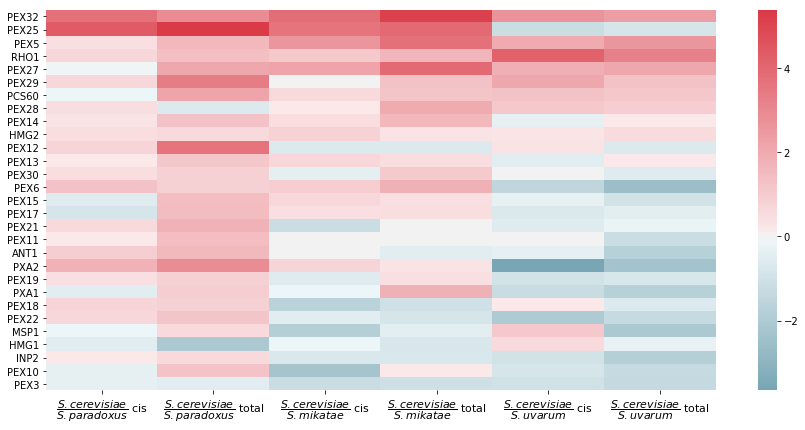

In [91]:
#make heat map for parents, all species



plt.figure(figsize=(20, 6))

fig, ax = plt.subplots(1, 1, figsize = (15, 7))

go5778_exp['means'] = go5778_exp[['Scer:Spar_parent', 'Scer:Spar_hybrid', 
                        'Scer:Smik_parent', 'Scer:Smik_hybrid', 
                        'Scer:Suva_parent', 'Scer:Suva_hybrid'
                       ]].mean(axis=1)

go5778_exp[['Scer:Spar_parent', 'Scer:Spar_hybrid', 
                        'Scer:Smik_parent', 'Scer:Smik_hybrid', 
                        'Scer:Suva_parent', 'Scer:Suva_hybrid'
                       ]]
go5778_exp = go5778_exp.sort_values('means', ascending=False)

# go5778_exp = go5778_exp.sort_values('Scer:Spar_hybrid', ascending=False)


sns.heatmap(go5778_exp[['Scer:Spar_hybrid','Scer:Spar_parent',  
                        'Scer:Smik_hybrid','Scer:Smik_parent',  
                        'Scer:Suva_hybrid','Scer:Suva_parent', 
                       ]], center=0,
            cmap=pal, xticklabels=[r'$\dfrac{S. cerevisiae}{S. paradoxus}$ cis', 
                                        r'$\dfrac{S. cerevisiae}{S. paradoxus}$ total',
                                        r'$\dfrac{S. cerevisiae}{S. mikatae}$ cis',
                                        r'$\dfrac{S. cerevisiae}{S. mikatae}$ total',
                                        r'$\dfrac{S. cerevisiae}{S. uvarum}$ cis',
                                        r'$\dfrac{S. cerevisiae}{S. uvarum}$ total'])


ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(axis="x", labelsize=11)

fig.savefig('/Users/clairedubin/spur/peroxisomes/paper_figures/figureS1.eps', format='eps')

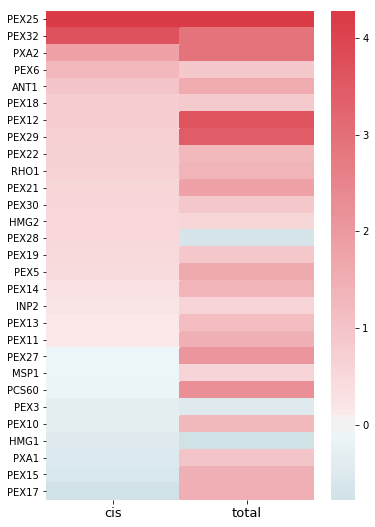

In [94]:
#scer:spar heat map, parent and hybrid

#means
go5778_exp = go5778_exp.sort_values('Scer:Spar_hybrid', ascending=False)

fig, ax = plt.subplots(1, 1, figsize = (6, 9))

# plt.figure(figsize=(10, 9))
pal=sns.color_palette(pal, 1000)
# plt.title('Log2 Fold Change in Expression (GO:0005778)')
sns.heatmap(go5778_exp[['Scer:Spar_hybrid', 'Scer:Spar_parent']], center=0,
            cmap=pal, cbar=True, robust=True, xticklabels=['cis', 'total'],ax=ax),
ax.set_ylabel('')    
ax.set_xlabel('')
ax.tick_params(axis="x", labelsize=13)


fig.savefig('/Users/clairedubin/spur/peroxisomes/paper_figures/figure2.eps', format='eps' )

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


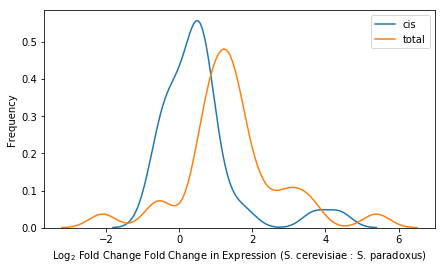

In [80]:
fig, ax = plt.subplots(1, 1, figsize = (7, 4))

sns.distplot(go5778_exp['Scer:Spar_hybrid'], hist=False, label='cis')
sns.distplot(go5778_exp['Scer:Spar_parent'], hist=False, label='total')
ax.set_xlabel('Log${_2}$ Fold Change Fold Change in Expression (S. cerevisiae : S. paradoxus)')
ax.set_ylabel('Frequency')
ax.legend()


In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (7, 4))

sns.distplot(go5778_exp['Scer:Spar_hybrid'].abs(), hist=False, label='cis')
sns.distplot(go5778_exp['Scer:Spar_parent'].abs(), hist=False, label='total')
ax.set_xlabel('Log${_2}$ Fold Change Fold Change in Expression (S. cerevisiae : S. paradoxus)')
ax.set_ylabel('Frequency')
ax.legend()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (7, 4))

sns.distplot(go5778_exp['Scer:Spar_hybrid'], hist=False, label='cis')
sns.distplot(go5778_exp['Scer:Spar_parent'], hist=False, label='total')
ax.set_xlabel('Log${_2}$ Fold Change Fold Change in Expression (S. cerevisiae : S. paradoxus)')
ax.set_ylabel('Frequency')
ax.legend()


In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (7, 4))

sns.distplot(hybrid['S_paradoxus'])
ax.set_xlim(-3,3)

In [ ]:
hybrid['S_mikatae'].median()

In [ ]:
hybrid['S_bayanus'].median()